In [1]:
from environments.SimplePlantSimulator import SimplePlantSimulator
from environments.SimplePlantSimulator import Daily_ContextBandit as ENV
import numpy as np
import matplotlib.pyplot as plt

In [2]:
env = ENV()
print(env.total_data_step)
print(env.steps_per_day, env.steps_per_night)
terminal_step = env.total_data_step

816
68 76


#### Test different lighting policies

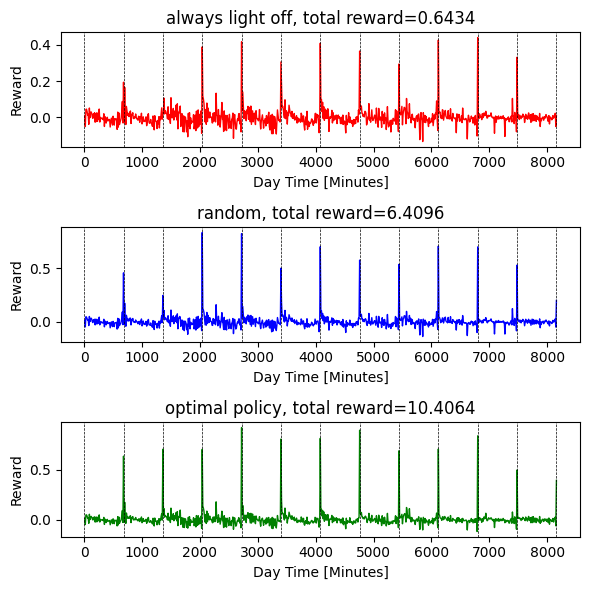

In [3]:
COLORS = ['r', 'b', 'g']
LABELS = ['always light off', 'random', 'optimal policy']
fig, ax = plt.subplots(3, 1, figsize=(6,6))

policy1 = np.zeros(terminal_step)
policy2 = np.random.choice([0, 1], terminal_step)
#policy3 = np.tile(np.hstack([np.ones(12), 2*np.ones(48), np.ones(12)]), env.last_day)
policy3 = np.ones(terminal_step)
policy = [policy1, policy2, policy3]

for i in range(3):
    env = ENV(reward_label='r1_percent')
    env.start()
    R = []  # reward
    State = []
    pol = policy[i]
    for _ in range(terminal_step):
        reward, next_state, done, info = env.step(int(pol[_]))
        R.append(reward)
        State.append(env.current_state)
    R = np.array(R)
    
    # Plot reward history
    ax[i].plot(np.arange(1, len(R)+1)*env.interval/60, R, linewidth=1, color=COLORS[i])
    #ax[i].plot(np.arange(1, len(R)+1)*env.interval/60, np.ones(len(R))*np.mean(R[R!=0]), color=COLORS[i], linewidth=1)
    ax[i].set_title(f'{LABELS[i]}, total reward={np.sum(R):.4f}')
    ax[i].set_xlabel('Day Time [Minutes]')
    ax[i].set_ylabel('Reward')    

for i in range(int(len(R)/env.steps_per_day)+1):
    ax[0].axvline(x = env.steps_per_day*i*env.interval/60, color='k', linestyle='--', linewidth=0.5)
    ax[1].axvline(x = env.steps_per_day*i*env.interval/60, color='k', linestyle='--', linewidth=0.5)
    ax[2].axvline(x = env.steps_per_day*i*env.interval/60, color='k', linestyle='--', linewidth=0.5)

fig.tight_layout()

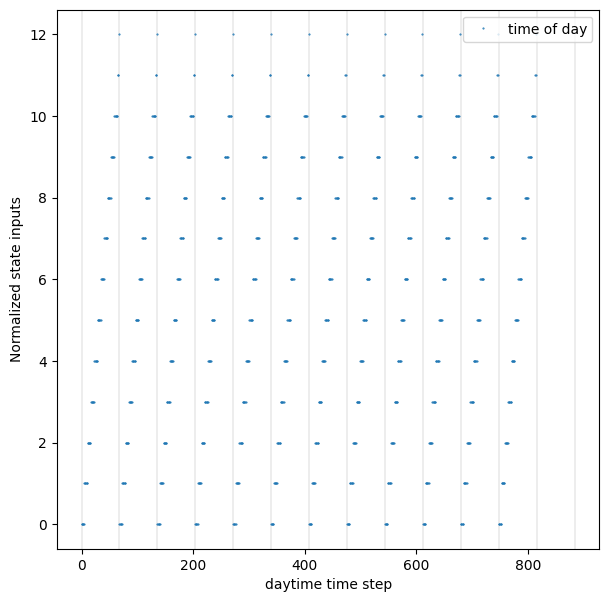

In [4]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
State = np.array(State)
for i in range(int(len(R)/env.steps_per_day)+2):
    ax.axvline(x = env.steps_per_day*i, color='k', linewidth=.1)
#ax.plot(State[:,:2], '.', markersize=2, label=['time of day','avg area'])
#ax.plot(State[:,2], linewidth=.5, label=[ 'plant motion'])
ax.plot(State[:,:], '.', markersize=1, label=[ 'time of day'])

ax.set_ylabel('Normalized state inputs')
ax.set_xlabel('daytime time step')
ax.legend()
#plt.ylim([0,1])

max return is 10.406
min return is 0.643


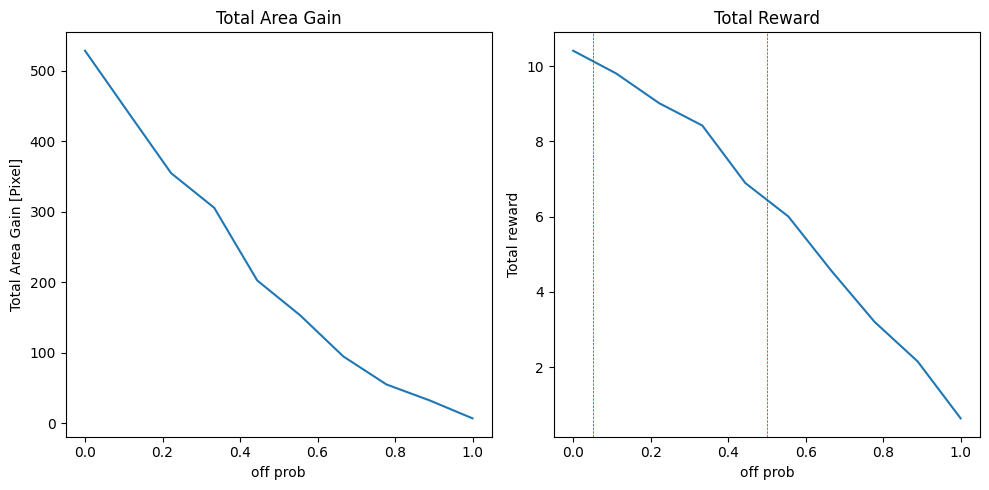

In [5]:
# See if return and total gain in area are positively correlated
num_sample = 10
episodic_return = []
area_gain = []
fig, ax = plt.subplots(1, 2, figsize=(10,5))   
for prob in np.linspace(0, 1, num_sample):
    env = ENV(reward_label='r1_percent')
    env.start()
    R = []; A = []
    for _ in range(terminal_step):
        reward, next_state, done, info = env.step(np.random.choice([0, 1], p = [prob, 1-prob]))
        A.append(np.mean([pwl(env.all_steps) for pwl in env.actual_areas]))
        R.append(reward)
    if prob == 0.5: 
        print(f'return for random policy is {np.sum(R):.3f}.')
    episodic_return.append(np.sum(R))
    area_gain.append(A[-1]-A[0])

print(f'max return is {np.max(episodic_return):.3f}')
print(f'min return is {np.min(episodic_return):.3f}')

ax[0].plot(np.linspace(0, 1, num_sample), area_gain)
ax[0].set_title('Total Area Gain')
ax[0].set_xlabel('off prob')
ax[0].set_ylabel('Total Area Gain [Pixel]')

ax[1].plot(np.linspace(0, 1, num_sample), episodic_return)
ax[1].axvline(x = 0.1/2, color='r', linestyle='--', linewidth=0.5)
ax[1].axvline(x = 0.5, color='r', linestyle='--', linewidth=0.5)
ax[1].set_title('Total Reward')
ax[1].set_xlabel('off prob')
ax[1].set_ylabel('Total reward')

fig.tight_layout()